In [ ]:
#Importar librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


In [ ]:
#Cargar archivos
subject_info = pd.read_csv('/content/subject-info.csv')
test_measure = pd.read_csv('/content/test_measure.csv')


In [ ]:
#Eliminar variables no deseadas
subject_info_clean = subject_info[['ID_test', 'Age', 'Weight', 'Height', 'Temperature', 'Sex']]
# Nos quedamos solo con las variables necesarias
test_measure_clean = test_measure[['ID_test', 'HR', 'RR', 'VO2']]

In [ ]:
# Paso 4.1: Eliminar filas que no tienen datos de VO2
test_measure_clean_vo2 = test_measure_clean.dropna(subset=['VO2'])

# Paso 4.2: Para cada prueba (ID_test), obtener la fila donde se alcanza el valor máximo de VO2
vo2max_data = test_measure_clean_vo2.loc[
    test_measure_clean_vo2.groupby('ID_test')['VO2'].idxmax()
]

# Paso 4.3: Verificar cuántas pruebas completas con VO2 tenemos
pruebas_totales = subject_info['ID_test'].nunique()
pruebas_con_vo2 = vo2max_data['ID_test'].nunique()

print(f"Pruebas con VO2 máximo detectado: {pruebas_con_vo2} de {pruebas_totales}")

Pruebas con VO2 máximo detectado: 981 de 992


In [ ]:
# Unimos por ID_test
final_data = pd.merge(vo2max_data, subject_info_clean, on='ID_test')

#Convertir VO2 a ml/kg/min
final_data["VO2ml_kg_min"] = final_data["VO2"] / final_data["Weight"]

# Imputar con la mediana
final_data['HR'] = final_data['HR'].fillna(final_data['HR'].median())
final_data['Temperature'] = final_data['Temperature'].fillna(final_data['Temperature'].median())

# Variables predictoras y objetivo
X = final_data[['Age', 'Weight', 'Height', 'Temperature', 'Sex', 'HR', 'RR']]
y = final_data["VO2ml_kg_min"]   #  nueva escala correcta



In [ ]:
# Ver valores faltantes por columna
print("Valores faltantes por columna:")
print(final_data.isnull().sum())

Valores faltantes por columna:
ID_test         0
HR              0
RR              0
VO2             0
Age             0
Weight          0
Height          0
Temperature     0
Sex             0
VO2ml_kg_min    0
dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [ ]:
y_pred = knn.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE del modelo KNN: {rmse:.2f}')

RMSE del modelo KNN: 9.09


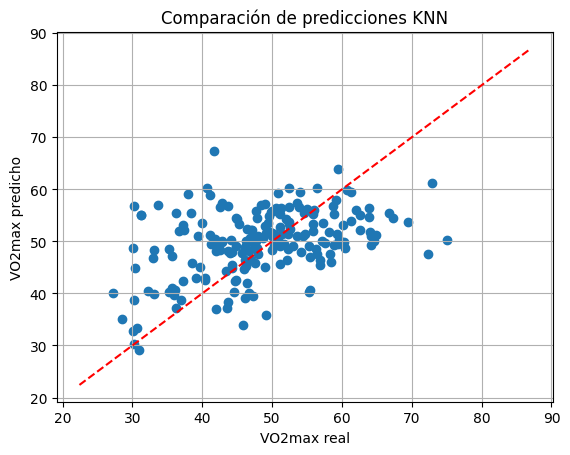

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("VO2max real")
plt.ylabel("VO2max predicho")
plt.title("Comparación de predicciones KNN")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.grid(True)
plt.show()


k = 1: RMSE = 10.06
k = 2: RMSE = 9.18
k = 3: RMSE = 9.09
k = 4: RMSE = 8.88
k = 5: RMSE = 8.85
k = 6: RMSE = 8.80
k = 7: RMSE = 8.64
k = 8: RMSE = 8.45
k = 9: RMSE = 8.45
k = 10: RMSE = 8.47
k = 11: RMSE = 8.46
k = 12: RMSE = 8.52
k = 13: RMSE = 8.50
k = 14: RMSE = 8.40
k = 15: RMSE = 8.44


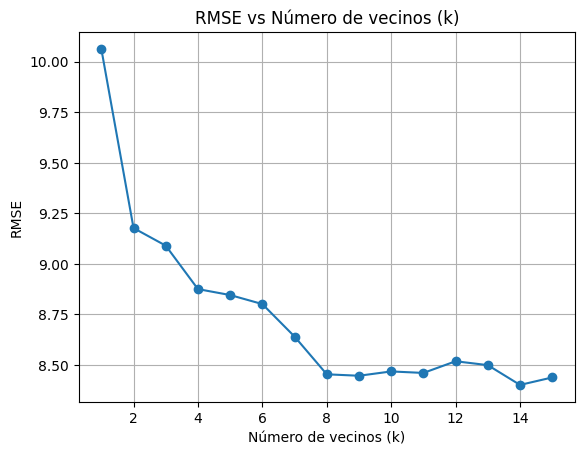

In [ ]:
import matplotlib.pyplot as plt

# Probar valores de k de 1 a 15
rmse_values = []
k_values = range(1, 16)

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)
    print(f'k = {k}: RMSE = {rmse:.2f}')

# Graficar los resultados
plt.plot(k_values, rmse_values, marker='o')
plt.title('RMSE vs Número de vecinos (k)')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


In [ ]:
knn = KNeighborsRegressor(n_neighbors=14, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE con ponderación por distancia: {rmse:.2f}')


RMSE con ponderación por distancia: 8.36


In [ ]:
#LASSO.

# 1. Importar librerías necesarias
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# 2. Estandarizar las variables predictoras (sin tocar las originales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Entrenar modelo LASSO
lasso = Lasso(alpha=1.0, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

# 4. Predicciones y evaluación
y_pred_lasso = lasso.predict(X_test_scaled)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f'RMSE del modelo LASSO: {rmse_lasso:.2f}')

# 5. Ver coeficientes de las variables
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coef_LASSO': lasso.coef_
})
print(coef_df)


RMSE del modelo LASSO: 8.15
      Variable  Coef_LASSO
0          Age   -0.000000
1       Weight   -1.877109
2       Height    0.000000
3  Temperature    0.000000
4          Sex   -2.606612
5           HR    0.000000
6           RR    1.915721


In [ ]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10]
rmse_values = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    y_pred = lasso.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)
    print(f'alpha = {a}: RMSE = {rmse:.2f}')


alpha = 0.0001: RMSE = 7.37
alpha = 0.001: RMSE = 7.37
alpha = 0.01: RMSE = 7.37
alpha = 0.1: RMSE = 7.40
alpha = 0.5: RMSE = 7.69
alpha = 1: RMSE = 8.15
alpha = 5: RMSE = 9.57
alpha = 10: RMSE = 9.57


In [ ]:
#SVR
from sklearn.svm import SVR

# Crear el modelo SVR con parámetros iniciales
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_scaled, y_train)

# Predecir y calcular RMSE
y_pred_svr = svr.predict(X_test_scaled)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
print(f'RMSE del modelo SVR: {rmse_svr:.2f}')


RMSE del modelo SVR: 7.81


In [ ]:
#AJUSTES SVR, distintos valores de C y epsilon con kernel 'rbf'
from sklearn.svm import SVR

c_values = [0.1, 1, 10, 100]
epsilons = [0.01, 0.1, 0.5]
best_rmse = float('inf')
best_params = None

for c in c_values:
    for eps in epsilons:
        svr = SVR(kernel='rbf', C=c, epsilon=eps)
        svr.fit(X_train_scaled, y_train)
        y_pred = svr.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f'C={c}, epsilon={eps} → RMSE = {rmse:.2f}')

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (c, eps)

print(f"\nMejor combinación: C={best_params[0]}, epsilon={best_params[1]} → RMSE = {best_rmse:.2f}")


C=0.1, epsilon=0.01 → RMSE = 8.72
C=0.1, epsilon=0.1 → RMSE = 8.72
C=0.1, epsilon=0.5 → RMSE = 8.72
C=1, epsilon=0.01 → RMSE = 7.80
C=1, epsilon=0.1 → RMSE = 7.81
C=1, epsilon=0.5 → RMSE = 7.81
C=10, epsilon=0.01 → RMSE = 7.65
C=10, epsilon=0.1 → RMSE = 7.64
C=10, epsilon=0.5 → RMSE = 7.61
C=100, epsilon=0.01 → RMSE = 8.53
C=100, epsilon=0.1 → RMSE = 8.51
C=100, epsilon=0.5 → RMSE = 8.45

Mejor combinación: C=10, epsilon=0.5 → RMSE = 7.61


In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Entrenar modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predecir y calcular RMSE
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'RMSE del modelo Random Forest: {rmse_rf:.2f}')

# Ver importancia de variables
importances = rf.feature_importances_
variables = X.columns

importancia_df = pd.DataFrame({
    'Variable': variables,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

print(importancia_df)


RMSE del modelo Random Forest: 7.83
      Variable  Importancia
1       Weight     0.245890
6           RR     0.209362
3  Temperature     0.123118
4          Sex     0.118065
0          Age     0.112316
2       Height     0.102929
5           HR     0.088319


In [ ]:
#XGBRegressor
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'RMSE del modelo XGBoost: {rmse_xgb:.2f}')


RMSE del modelo XGBoost: 7.84



Correlación de cada variable con VO2max (ordenada):
RR             0.367558
HR             0.111087
Height         0.092747
Temperature    0.059879
Age           -0.144171
Weight        -0.238938
Sex           -0.358585
Name: VO2ml_kg_min, dtype: float64


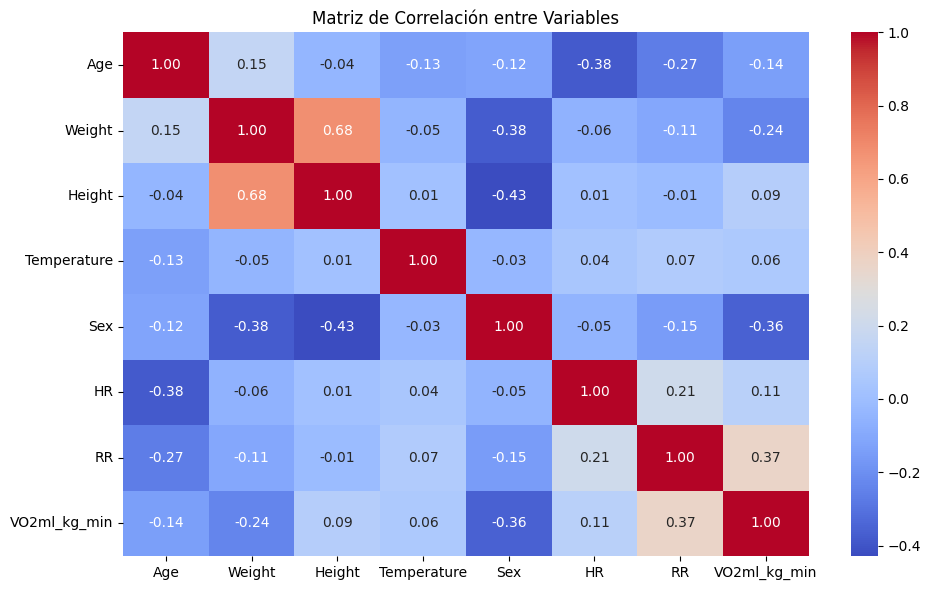

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Unir X e y para análisis de correlación
df_corr = pd.concat([X, y], axis=1)

# Calcular matriz de correlación
corr_matrix = df_corr.corr()

# Mostrar correlación ordenada respecto a VO2
print("\nCorrelación de cada variable con VO2max (ordenada):")
print(corr_matrix['VO2ml_kg_min'].drop('VO2ml_kg_min').sort_values(ascending=False))

# Graficar heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación entre Variables")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# KNN
mae_knn = mean_absolute_error(y_test, y_pred)
r2_knn = r2_score(y_test, y_pred)
print(f'KNN → MAE: {mae_knn:.2f}, R²: {r2_knn:.2f}')

# LASSO
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f'LASSO → MAE: {mae_lasso:.2f}, R²: {r2_lasso:.2f}')

# SVR
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print(f'SVR → MAE: {mae_svr:.2f}, R²: {r2_svr:.2f}')

# Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest → MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}')

# XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost → MAE: {mae_xgb:.2f}, R²: {r2_xgb:.2f}')



KNN → MAE: 6.66, R²: 0.22
LASSO → MAE: 6.38, R²: 0.27
SVR → MAE: 5.91, R²: 0.33
Random Forest → MAE: 6.07, R²: 0.33
XGBoost → MAE: 6.10, R²: 0.33


In [ ]:
from sklearn.linear_model import LinearRegression

# Entrenar modelo de regresión lineal múltiple
mlr = LinearRegression()
mlr.fit(X_train, y_train)

# Predecir y calcular métricas
y_pred_mlr = mlr.predict(X_test)

rmse_mlr = np.sqrt(mean_squared_error(y_test, y_pred_mlr))
mae_mlr = mean_absolute_error(y_test, y_pred_mlr)
r2_mlr = r2_score(y_test, y_pred_mlr)

print(f'MLR → RMSE: {rmse_mlr:.2f}, MAE: {mae_mlr:.2f}, R²: {r2_mlr:.2f}')


MLR → RMSE: 7.37, MAE: 5.79, R²: 0.40
